In [1]:
%matplotlib inline
import re
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import joblib
from joblib import Parallel, delayed
from tqdm.notebook import tqdm as tqdm
from tqdm.notebook import trange
import contextlib
import numpy as np
import pandas as pd
from scipy.special import digamma
from scipy.stats import norm as normal
from pickle import dump, load
from scipy.sparse import csr_matrix
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel, Word2Vec
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string
import os
import sys
import time




/home/iron/Repositories/classes/ml_2_classes/ML2_Exercises/pgm/ex9/.env/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
tqdm.pandas()

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()  

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/iron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/iron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/iron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
n = 25

seed = 42
data_train = pd.read_csv("data/papers.csv")["paper_text"]
data_train.head()

0    767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1    683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2    394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3    Bayesian Query Construction for Neural\nNetwor...
4    Neural Network Ensembles, Cross\nValidation, a...
Name: paper_text, dtype: object

In [5]:
data_train

0       767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1       683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2       394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3       Bayesian Query Construction for Neural\nNetwor...
4       Neural Network Ensembles, Cross\nValidation, a...
                              ...                        
7236    Single Transistor Learning Synapses\n\nPaul Ha...
7237    Bias, Variance and the Combination of\nLeast S...
7238    A Real Time Clustering CMOS\nNeural Engine\nT....
7239    Learning direction in global motion: two\nclas...
7240    Correlation and Interpolation Networks for\nRe...
Name: paper_text, Length: 7241, dtype: object

In [6]:
data = pd.Series(data_train).sample(n).copy()
data.reset_index(drop=True, inplace=True)
data.head()

0    Variational Inference for Crowdsourcing\n\nQia...
1    Learning a Concept Hierarchy from\nMulti-label...
2    Online combinatorial optimization with stochas...
3    Inferring sparse representations of continuous...
4    Pruning Random Forests for Prediction on a Bud...
Name: paper_text, dtype: object

In [7]:
clean_stem_filters = [strip_tags,
                        strip_numeric,
                        strip_punctuation, 
                        lambda x: x.lower(),
                        lambda s: re.sub(r'\b\w{1,2}\b', ' ', s),
                        strip_multiple_whitespaces,
                        remove_stopwords
                     ]

def text_processing(document):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(i) for i in preprocess_string(document, clean_stem_filters)]

In [8]:
def proc_func(data):
    with tqdm_joblib(tqdm(desc="Preprocessing", total=len(data))) as progress_bar:
        data_proc = Parallel(n_jobs=1)(delayed(text_processing)(text) for text in data)
        data_proc = pd.Series(data_proc, index=data.index, name='data')
    return data_proc

In [9]:
data_proc = proc_func(data)
data_proc.head()

Preprocessing:   0%|          | 0/25 [00:00<?, ?it/s]

0    [variational, inference, crowdsourcing, qiang,...
1    [learning, concept, hierarchy, multi, labeled,...
2    [online, combinatorial, optimization, stochast...
3    [inferring, sparse, representation, continuous...
4    [pruning, random, forest, prediction, budget, ...
Name: data, dtype: object

In [10]:
def encode2(text, word_dict):
    return np.asarray(word_dict.doc2idx(text))

In [11]:
word_dict = Dictionary(data_proc)
data_enc = data_proc.progress_apply(lambda x: encode2(x, word_dict))

  0%|          | 0/25 [00:00<?, ?it/s]

In [12]:
D = len(data_enc)
Ns = data_enc.apply(lambda x: len(x)).to_numpy().astype(int)
N = Ns.sum()
V = len(word_dict)
Gs = [None] * D

In [13]:
print(D, Ns, N, V, len(Gs))

25 [2622 2885 2381 2166 2257 2380 2363 1342 2922 3159 2645 1957 1875 2902
 1390 3129 2011 3101 2289 2298 2436 1135 2690 2577  998] 57910 6827 25


In [14]:
# https://people.eecs.berkeley.edu/~jordan/papers/hdp.pdf
# https://www.cs.toronto.edu/~radford/ftp/mixmc.pdf

In [64]:
class DP0:
    def __init__(self, a, H_var):
        self.a = a
        self.H_var = H_var
        self.H = normal(0, np.sqrt(H_var))
        self.K = 0 # Dishes
        self.phi_k = [] # Dish ID
        self.t_k = [] # Number of tables serving dish K

        # Sufficient statistics
        self.phi_k_mean = []
        self.phi_k_dist = []
        self.n_k = []
        
    def init_sample(self):
        denom = 1./(sum(self.t_k)+self.a)
        alphas = np.asarray(self.t_k + [self.a]) * denom
        probs = np.random.dirichlet(alphas)
        k = np.random.choice(range(self.K+1), p=probs)
        if k+1 > self.K:
            self._create_table()

        return self.phi_k[k], k
    
    def sample(self):
        denom = 1./(sum(self.t_k) + self.a)

        post_var = dp.H_var / (1. + np.asarray(self.n_k))
#         post_mean = post_var * dp.phi_k_mean/dp.H_var
        
        int_fh = ( 1. / np.sqrt(2 * np.pi * (self.H_var + post_var)) ) #  * np.exp(-(1./post_var) * np.square(v-post_mean))
        int_fg0 = 1. / np.sqrt(2 * np.pi * (self.H_var+self.H_var))

        alphas = np.asarray(list(self.n_k * int_fh) + [self.a * int_fg0]) * denom
        alphas /= np.sum(alphas)
        alphas += 1e-15
        probs = np.random.dirichlet(alphas)
        
        k = np.random.choice(range(self.K+1), p=probs)
        if k+1 > self.K:
            self._create_table()

        return self.phi_k[k], k
    
    def _create_table(self):
        self.K += 1
        self.phi_k.append(self.H.rvs())
        self.phi_k_mean.append(0)
        self.n_k.append(0)
        self.phi_k_dist.append(normal(self.phi_k[-1], np.sqrt(self.H_var)))
            
    def increase_dish_count(self, dish):
        if len(self.t_k) <= dish:
            self.t_k += [0] * ((dish+1) - len(self.t_k))
        self.t_k[dish] += 1

    def decrease_dish_count(self, dish):
        if len(self.t_k) > dish:
            self.t_k[dish] -= 1
            
    def update_ks(self):
        for i in range(self.K):
            mean = self.phi_k_mean[i]/self.n_k[i] if self.n_k[i] != 0 else 0
            self.phi_k_dist[i] = normal(mean, np.sqrt(self.H_var))
            self.phi_k[i] = mean

class DP1:
    def __init__(self, a, DP, words):
        self.a = a
        self.G = DP[0]
        self.t = 0 # Num tables
        self.m = [] # Num of tables serving k
        self.n_t = [] # Num of customers at table t
        self.k_t = [] # Index of phi_k corresponding
        self.theta_i = [None] * len(words) # Table index where customer i sits
        self.words = words
        self.embeddings = np.zeros(len(words))
        
        self.t_means = []
        
        self._init_sample()
        
    def _init_sample(self):
        for i in range(len(self.words)):
            denom = 1./(i+self.a)
            if len(self.n_t) == 0:
                alphas = np.asarray([self.a * denom])
            else:
                alphas = np.asarray(self.n_t + [self.a]) * denom
            alphas += 1e-15
            probs = np.random.dirichlet(alphas)
            t = np.random.choice(range(self.t+1), p=probs)
            if t+1 > self.t:
                self._init_create_table()
                    
            self.n_t[t] += 1
            self.theta_i[i] = t
            k = self.k_t[self.theta_i[i]]
            self.embeddings[i] = self.G.phi_k_dist[k].rvs()
            self.t_means[t] += self.embeddings[i]
            self.G.phi_k_mean[k] += self.embeddings[i]
            self.G.n_k[k] += 1 
    
    def _init_create_table(self):
        self.t += 1
        phi_k, k = self.G.init_sample()
        self.k_t.append(k)
        if len(self.m) <= k:
            self.m.append(1)
        else:
            self.m[k] += 1
        if len(self.n_t) <= self.t:
            self.n_t.append(0)
            self.t_means.append(0)
                
        self.G.increase_dish_count(k)
        
    def _create_table(self):
        self.t += 1
        phi_k, k = self.G.sample()
        self.k_t.append(k)
        if len(self.m) <= k:
            self.m.append(1)
        else:
            self.m[k] += 1
        if len(self.n_t) <= self.t:
            self.n_t.append(0)
            self.t_means.append(0)
                
        self.G.increase_dish_count(k)
        
    def swipe(self):
        idxs = list(range(len(self.words)))
        np.random.shuffle(idxs)
        for i in idxs:
            v = self.embeddings[i]
            t_ = self.theta_i[i]
            k_ = self.k_t[t_]
            
            denom = 1./(sum(dp.t_k)+dp.a)

            self.G.phi_k_mean[k_] -= v
            self.G.n_k[k_] -= 1
            self.t_means[t_] -= self.embeddings[i]
            
            if self.G.n_k[k_] < 0:
                print("Found 0 at g.n_k[{}]".format(k_))
                self.G.n_k[k_] = 0
            
            self.n_t[t_] -= 1
            
            if self.n_t[t_] == 0:
                self.G.decrease_dish_count(k_)
            
            if self.n_t[t_] < 0:
                print("Found 0 at n_t[{}]".format(t_))
                self.n_t[t_] = 0

            post_var = self.G.H_var / (1. + np.asarray(self.n_t))
            post_mean = post_var * np.asarray(self.t_means)/self.G.H_var
            
            int_fh = (1. / np.sqrt(2 * np.pi * (self.G.H_var + post_var)) ) * np.exp(-(1./(self.G.H_var + post_var)) * np.square(v-post_mean))
            int_fg0 = 1. / np.sqrt(2 * np.pi * (self.G.H_var + self.G.H_var)) * np.exp(-(1./(self.G.H_var + self.G.H_var)) * np.square(v))

            alphas = np.asarray(list(self.n_t * int_fh) + [self.G.a * int_fg0]) * denom
            alphas /= np.sum(alphas)
            alphas += 1e-15
            probs = np.random.dirichlet(alphas)
            
            t = np.random.choice(range(self.t+1), p=probs)
            
            if t+1 > self.t:
                self._create_table()
                
            self.n_t[t] += 1
            self.theta_i[i] = t
            k = self.k_t[t]
            self.embeddings[i] = self.G.phi_k_dist[k].rvs()
            self.t_means[t] += self.embeddings[i]
            self.G.phi_k_mean[k] += self.embeddings[i]
            self.G.n_k[k] += 1 

In [65]:
H_var = 1
a = 5
a, H_var

(5, 1)

In [66]:
dp = [DP0(a, H_var)][0]
gjs = []

In [67]:
for d in tqdm(data_enc):
    gjs.append(DP1(5, [dp], list(d)))

  0%|          | 0/25 [00:00<?, ?it/s]

In [68]:
dp.t_k

[25, 303, 106, 46, 133, 53, 22, 7, 16, 42, 1, 3, 9, 1, 2, 1, 1, 1]

In [69]:
dp.n_k

[2989,
 22430,
 5173,
 3547,
 10484,
 4695,
 2655,
 273,
 1133,
 2772,
 11,
 867,
 687,
 23,
 5,
 98,
 67,
 1]

In [70]:
[i for i, v in enumerate(dp.n_k) if v != 0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

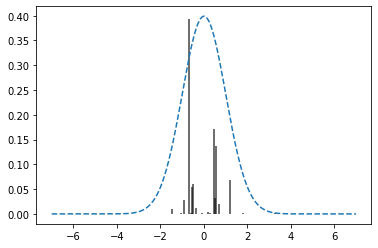

In [71]:
import matplotlib.pyplot as plt

x = np.arange(-7, 7, 0.01)
y = dp.H.pdf(x)

plt.plot(x, y, linestyle='--')

plt.vlines(dp.phi_k, ymin=0, ymax=np.array(dp.t_k)/sum(dp.t_k), color='k', alpha=0.75)

In [72]:
dp.update_ks()

  0%|          | 0/200 [00:00<?, ?it/s]

invalid command name "139821666249920delayed_destroy"
    while executing
"139821666249920delayed_destroy"
    ("after" script)


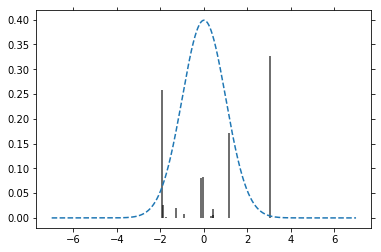

In [73]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = np.arange(-7, 7, 0.01)
y = dp.H.pdf(x)

for i in tqdm(range(200)):
    for g in gjs:
        g.swipe()
    dp.update_ks()
    
    ax.clear()
    ax.plot(x, y, linestyle='--')
    ax.vlines(dp.phi_k, ymin=0, ymax=np.array(dp.t_k)/sum(dp.t_k), color='k', alpha=0.75)

    plt.pause(0.05)


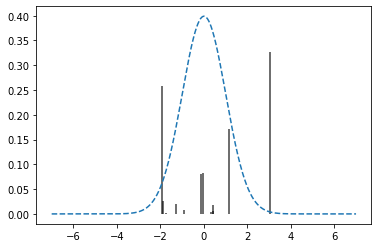

In [74]:
import matplotlib.pyplot as plt

x = np.arange(-7, 7, 0.01)
y = dp.H.pdf(x)

plt.plot(x, y, linestyle='--')

plt.vlines(dp.phi_k, ymin=0, ymax=np.array(dp.t_k)/sum(dp.t_k), color='k', alpha=0.75)

In [75]:
dp.t_k

[4, 1, 14, 67, 66, 140, 0, 16, 0, 6, 266, 211, 3, 21, 0, 0, 0, 0, 0]

In [76]:
dp.n_k

[145,
 42,
 1176,
 3898,
 4589,
 10822,
 0,
 446,
 0,
 302,
 19683,
 15658,
 300,
 849,
 0,
 0,
 0,
 0,
 0]

In [77]:
[i for i, v in enumerate(dp.n_k) if v != 0]

[0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13]

In [78]:
dp.K

19

In [79]:
k_counts = np.zeros((V, dp.K))

for g in gjs:
    for w in np.unique(g.words):
        ts = np.asarray(g.theta_i)[np.where(g.words == w)]
        ks = np.asarray(g.k_t)[ts]
        ks, counts = np.unique(ks, return_counts=True)
        k_counts[w, ks] += counts
        
k_counts

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [80]:
word_topic_counts = k_counts[:,k_counts.sum(axis=0) > 0]
word_topic_counts

array([[ 0.,  0.,  0., ..., 12.,  0.,  0.],
       [ 0.,  0.,  0., ..., 23.,  0.,  0.],
       [ 0.,  0.,  1., ..., 10.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [81]:
word_topic_counts.shape

(6827, 12)

In [82]:
np.flip(np.sort(word_topic_counts, axis=0)[-10:].T, axis=1)

array([[  6.,   6.,   5.,   4.,   3.,   3.,   2.,   2.,   2.,   2.],
       [  2.,   2.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
       [ 15.,  14.,  13.,   9.,   8.,   8.,   8.,   8.,   7.,   7.],
       [ 48.,  39.,  38.,  34.,  32.,  27.,  27.,  26.,  25.,  25.],
       [ 46.,  37.,  34.,  28.,  28.,  28.,  27.,  27.,  27.,  25.],
       [115., 101.,  93.,  84.,  78.,  64.,  64.,  59.,  54.,  54.],
       [  7.,   7.,   4.,   4.,   4.,   4.,   3.,   3.,   3.,   3.],
       [  6.,   5.,   4.,   4.,   3.,   3.,   3.,   3.,   3.,   3.],
       [185., 180., 177., 152., 141., 112., 103.,  99.,  96.,  94.],
       [168., 142., 131., 113., 106.,  95.,  89.,  84.,  83.,  81.],
       [  5.,   5.,   4.,   4.,   4.,   3.,   3.,   3.,   3.,   3.],
       [ 19.,  15.,  11.,  11.,   8.,   8.,   8.,   7.,   7.,   6.]])

In [83]:
topics_encoded = np.flip(np.argsort(word_topic_counts, axis=0)[-15:].T, axis=1)
topics = []
for i, t in enumerate(topics_encoded):
    topic_words = []
    for j, w in enumerate(t):
        if t[j] == 0:
            break
        topic_words.append(word_dict[w])
    topics.append(topic_words)
        
topics

[['matrix',
  'method',
  'rank',
  'figure',
  'noise',
  'log',
  'general',
  'armp',
  'affine',
  'iteration',
  'data',
  'application',
  'svt',
  'restricted',
  'problem'],
 ['value',
  'bandit',
  'bound',
  'optimal',
  'referred',
  'according',
  'believe',
  'typical',
  'error',
  'present',
  'significantly',
  'help',
  'potential',
  'kaplan',
  'lai'],
 ['method',
  'test',
  'model',
  'matrix',
  'statistic',
  'data',
  'result',
  'node',
  'learning',
  'precision',
  'time',
  'based',
  'algorithm',
  'difference',
  'maximum'],
 ['learning',
  'function',
  'algorithm',
  'model',
  'task',
  'feature',
  'reward',
  'topic',
  'set',
  'data',
  'parameter',
  'value',
  'method',
  'document',
  'performance'],
 ['time',
  'algorithm',
  'function',
  'model',
  'topic',
  'distribution',
  'set',
  'method',
  'problem',
  'vector',
  'use',
  'space',
  'value',
  'result',
  'log'],
 ['function',
  'algorithm',
  'model',
  'time',
  'learning',
  'metho

In [35]:
topics_encoded

array([[ 333,  542,   25, ..., 4487, 4488,    0],
       [ 333,   25,  542, ..., 5658, 3353, 4349],
       [6513,  437,  469, ..., 4540, 4541,    0],
       [ 333,   25,  542, ..., 3942, 3937, 3413]])